In [1]:
import pyodbc
import sqlalchemy
import pandas as pd
import numpy as np
import json
from datetime import datetime as dt
from datetime import timedelta
from matplotlib import pyplot as plt
from pylab import rcParams
%matplotlib inline

In [2]:
# server connection

with open(f'/Users/terrill/Documents/work/stuff/spy_trend/sql_server_info_equities.txt', 'r') as f:
    line = f.readline().split(',')
name, user, password = line[0], line[3], line[4]

sqlalchemy.create_engine(f'mssql+pyodbc://{user}:{password}@{name}')
%load_ext sql
%sql mssql+pyodbc://$user:$password@$name
%config SqlMagic.displaycon = False

<h5>Cleaning up Yahoo data</h5>

In [3]:
def clean_yahoo_df(df, ticker):
    df.drop(['HighPrice','LowPrice','OpenPrice'], axis=1, inplace=True)
    df = df.astype({'ClosePrice': 'float'})
    df['ClosePrice'] = df['ClosePrice'].round(2)
    #df['Volume'] = df['Volume'].astype('int32')
    df.rename(columns={'Volume': f'{ticker}_Volume', 'ClosePrice': ticker}, inplace=True)
    df.set_index('Date', inplace=True)
    
    return df

In [4]:
%%capture

main_df = %sql select * from equities.dbo.spy order by date

main_df = clean_yahoo_df(main_df.DataFrame(), 'SPY')

In [5]:
main_df.tail()

,SPY,SPY_Volume
Date,,
2020-06-26,300.05,127961000
2020-06-29,304.46,79773300
2020-06-30,308.36,113394800
2020-07-01,310.52,72396500
2020-07-02,312.23,69344200


A few economic indicators are updated weekly, monthly, etc. Some of those days are on the weekend when equity markets are not opened. For that, we will have to outer join those dataframes with the main dataframes, forward fill the NaN data, and remove weekend dates. Below is the list of SPY dates that will be used later.

In [6]:
spy_dates = list(main_df.index)

Below are all tickers pulled from Yahoo and saved locally. I will need to find a way to automate the refresh daily but for now will use the data I have to optimize the model.

Also note, for the individual sector ETFs, I will use Vanguard ETFs instead of SPDR even if SPY is an SPDR ETFs. Even though most of the SPDR ETFs are larger and more liquid I find the Vanguard ETFs more accurately reflects their respective idustries as the portfolios include small and mid caps. SPDR ETFs are heavily concentrated in stocks already included in SPY.

In [7]:
etfs = ['QQQ', 'IWM', 'TLT', 'IEF', 'VNQ', 'VGT', 'VHT', 'VFH', 'VCR', 'VIS', 'VDC', 'VPU', 'VDE', 'VAW', 'VOX']

futures = ['CL=F', 'GC=F', 'SI=F', 'ZF=F', 'ZN=F']

In [8]:
%%capture

for ticker in etfs:
    query = %sql SELECT * FROM Equities.dbo.$ticker ORDER BY date DESC
    temp_df = clean_yahoo_df(query.DataFrame(), ticker)
    main_df = main_df.join(temp_df, how='left')

for ticker in futures:
    new_ticker = ticker.replace('=','_')
    query = %sql SELECT * FROM Futures.dbo.$new_ticker ORDER BY date DESC
    temp_df = clean_yahoo_df(query.DataFrame(), ticker)
    main_df = main_df.join(temp_df, how='left')

In [9]:
main_df.tail(3)

,SPY,SPY_Volume,QQQ,QQQ_Volume,IWM,IWM_Volume,TLT,TLT_Volume,IEF,IEF_Volume,...,CL=F,CL=F_Volume,GC=F,GC=F_Volume,SI=F,SI=F_Volume,ZF=F,ZF=F_Volume,ZN=F,ZN=F_Volume
Date,,,,,,,,,,,,,,,,,,,,,
2020-06-30,308.36,113394800,247.60,38909200.0,143.18,32865900.0,163.74,14841700.0,121.76,4126700.0,...,39.66,143721086.0,1800.4,87426446.0,18.60,27498487.0,125.74,222311932.0,139.16,436197367.0
2020-07-01,310.52,72396500,250.49,34689200.0,141.82,26457500.0,163.42,13181000.0,121.57,8416500.0,...,39.61,171886332.0,1778.3,128714431.0,18.26,40526778.0,125.60,247177437.0,138.94,524020934.0
2020-07-02,312.23,69344200,252.19,31956500.0,142.40,24022400.0,163.59,7599800.0,121.72,3054100.0,...,40.32,130102415.0,1787.1,89155862.0,18.25,21540289.0,125.73,175910173.0,139.16,405103512.0


<h5>Other charts (Treasure bond yields, Libor rate, Mortgage rate, M1 & M2 money supply, VIX, DIX)</h5>
<br>
Data pulled from various sources.

In [10]:
# maybe include VVIX in the future?
# Notes:
# 30 year fixed mortgage rate is updated monthly (need may numbers)
# money supply data is updated weekly

economics_tickers = ['CPIAUCSL', 'DFF', 'DGS10', 'DGS30', 'M1', 'M2', 'MORTGAGE15US', 'MORTGAGE30US',
                     'T10YIE', 'USD1MTD156N', 'USD6MTD156N', 'USD12MD156N']
economic_names = ['CPI', 'Fed_Funds_Rate', '10_yr_Treasury', '30_yr_Treasury', 'M1_Supply',
                  'M2_Supply', '15_yr_Mortgage', '30_yr_Mortgage', '10_yr_Inflation',
                  '1m_Libor', '3m_Libor', '12m_Libor']
  #10_yr_Treasury, 30_yr_Treasury, 15_yr_Mortgage, 30_yr_Mortgage, 10_yr_Inflation, 1m_Libor, 3m_Libor, 12m_Libor
forex = ['USD_JPY', 'USD_EUR', 'USD_CHF', 'USD_PLN', 'USD_CNY', 'USD_HUF', 'USD_RUB', 'USD_CAD',
         'USD_RON', 'USD_INR', 'USD_GBP', 'USD_AUD', 'USD_HKD', 'USD_SEK', 'USD_SGD', 'XAU_USD',
         'DXY']

vix = 'I_VIX'
dix = 'DIX'

In [11]:
%%capture

# economics data
for ticker, name in zip(economics_tickers, economic_names):
    query = %sql SELECT * FROM Economics.dbo.$ticker WHERE Date >= '1993-01-01' ORDER BY date
    temp_df = query.DataFrame()
    temp_df.set_index('Date', inplace=True)
    temp_df.rename(columns={temp_df.columns[0]: name}, inplace=True)
    if ticker in ['M1', 'M2']:
        temp_df *= 1000000000
    temp_df = temp_df.astype({name: 'float'})
    main_df = main_df.join(temp_df, how='outer')

# forex
for ticker in forex:
    query = %sql SELECT * FROM Forex.dbo.$ticker WHERE Date >= '1993-01-01' ORDER BY date
    temp_df = query.DataFrame()
    temp_df.drop(['OpenPrice', 'HighPrice', 'LowPrice'], axis=1, inplace=True)
    temp_df = temp_df.astype({'ClosePrice': 'float'})
    temp_df['ClosePrice'] = temp_df['ClosePrice'].round(2)
    temp_df.set_index('Date', inplace=True)
    temp_df.rename(columns={'ClosePrice': ticker}, inplace=True)
    main_df = main_df.join(temp_df, how='left')

# vix
query = %sql SELECT * FROM Equities.dbo.I_VIX WHERE Date >= '1993-01-01' ORDER BY date
temp_df = query.DataFrame()
temp_df.drop(['HighPrice', 'LowPrice', 'OpenPrice'], axis=1, inplace=True)
temp_df = temp_df.astype({'ClosePrice': 'float'})
temp_df['ClosePrice'] = temp_df['ClosePrice'].round(2)
temp_df.set_index('Date', inplace=True)
temp_df.rename(columns={'ClosePrice': 'VIX'}, inplace=True)
main_df = main_df.join(temp_df, how='left')

# # dix (leaving this out for now)
# query = %sql SELECT * FROM Equities.dbo.I_DIX ORDER BY date
# temp_df = query.DataFrame()
# temp_df.drop(['SPX'], axis=1, inplace=True)
# temp_df = temp_df.astype({'DIX': 'float', 'GEX': 'float'})
# temp_df.set_index('Date', inplace=True)
# main_df = main_df.join(temp_df, how='left')

In [12]:
main_df.iloc[:,:].tail()

,SPY,SPY_Volume,QQQ,QQQ_Volume,IWM,IWM_Volume,TLT,TLT_Volume,IEF,IEF_Volume,...,USD_RON,USD_INR,USD_GBP,USD_AUD,USD_HKD,USD_SEK,USD_SGD,XAU_USD,DXY,VIX
Date,,,,,,,,,,,,,,,,,,,,,
2020-06-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-06-29,304.46,79773300.0,242.84,34377800.0,141.14,33935200.0,164.54,7274400.0,121.98,28632400.0,...,4.31,75.51,0.81,1.46,7.75,9.33,1.39,1772.28,97.54,31.78
2020-06-30,308.36,113394800.0,247.60,38909200.0,143.18,32865900.0,163.74,14841700.0,121.76,4126700.0,...,4.31,75.54,0.81,1.45,7.75,9.32,1.39,1781.67,97.39,30.43
2020-07-01,310.52,72396500.0,250.49,34689200.0,141.82,26457500.0,163.42,13181000.0,121.57,8416500.0,...,4.31,75.49,0.80,1.45,7.75,9.31,1.39,1770.31,97.20,28.62
2020-07-02,312.23,69344200.0,252.19,31956500.0,142.40,24022400.0,163.59,7599800.0,121.72,3054100.0,...,4.30,74.75,0.80,1.44,7.75,9.32,1.39,1776.14,97.32,27.68


Forward fill any data that is updated weekly, monthly, etc. Remove all dates when market is closed (weekends, holidays).

In [13]:
main_df.ffill(inplace=True)

In [14]:
main_df = main_df[main_df.index.isin(spy_dates)]
main_df.head(3)

,SPY,SPY_Volume,QQQ,QQQ_Volume,IWM,IWM_Volume,TLT,TLT_Volume,IEF,IEF_Volume,...,USD_RON,USD_INR,USD_GBP,USD_AUD,USD_HKD,USD_SEK,USD_SGD,XAU_USD,DXY,VIX
Date,,,,,,,,,,,,,,,,,,,,,
1993-01-29,26.18,1003200.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,31.38,0.67,1.47,7.73,7.30,1.65,329.85,92.46,12.42
1993-02-01,26.37,480500.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,31.42,0.69,1.48,7.74,7.46,1.65,329.85,93.56,12.33
1993-02-02,26.43,201300.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,31.62,0.69,1.47,7.74,7.44,1.65,329.65,93.92,12.25


<h5>Last Value Method</h5>
We will be shifiting the target value up by one day, meaning we will set the current adjusted closing price as the previous day's adjusted closing price for the predictions.

In [15]:
main_df['target_SPY_1d'] = main_df['SPY'].shift(-1)
main_df.drop(main_df.tail(1).index, inplace=True)
main_df.drop('SPY', axis=1, inplace=True)

In [16]:
main_df.tail(3)

,SPY_Volume,QQQ,QQQ_Volume,IWM,IWM_Volume,TLT,TLT_Volume,IEF,IEF_Volume,VNQ,...,USD_INR,USD_GBP,USD_AUD,USD_HKD,USD_SEK,USD_SGD,XAU_USD,DXY,VIX,target_SPY_1d
Date,,,,,,,,,,,,,,,,,,,,,
2020-06-29,79773300.0,242.84,34377800.0,141.14,33935200.0,164.54,7274400.0,121.98,28632400.0,77.61,...,75.51,0.81,1.46,7.75,9.33,1.39,1772.28,97.54,31.78,308.36
2020-06-30,113394800.0,247.60,38909200.0,143.18,32865900.0,163.74,14841700.0,121.76,4126700.0,78.53,...,75.54,0.81,1.45,7.75,9.32,1.39,1781.67,97.39,30.43,310.52
2020-07-01,72396500.0,250.49,34689200.0,141.82,26457500.0,163.42,13181000.0,121.57,8416500.0,80.34,...,75.49,0.80,1.45,7.75,9.31,1.39,1770.31,97.20,28.62,312.23


<h5>Getting Rolling Mean and Standard Deviation</h5>
To be used later to inverse scale predictions. We will try using the 5 day rolling mean and std for now and then experiment with other days later.

In [17]:
main_df['SPY_mean'] = main_df['target_SPY_1d'].rolling(window=5, min_periods=1).mean()
main_df['SPY_std'] = main_df['target_SPY_1d'].rolling(window=5, min_periods=1).std()
main_df.tail()

,SPY_Volume,QQQ,QQQ_Volume,IWM,IWM_Volume,TLT,TLT_Volume,IEF,IEF_Volume,VNQ,...,USD_AUD,USD_HKD,USD_SEK,USD_SGD,XAU_USD,DXY,VIX,target_SPY_1d,SPY_mean,SPY_std
Date,,,,,,,,,,,,,,,,,,,,,
2020-06-25,89468000.0,246.03,36940800.0,140.45,37191200.0,163.31,10968000.0,121.53,1650900.0,77.63,...,1.45,7.75,9.32,1.39,1761.81,97.43,32.22,300.05,306.832,4.882594
2020-06-26,127961000.0,240.22,52824600.0,136.67,39100100.0,165.06,12119300.0,121.86,3413900.0,76.14,...,1.46,7.75,9.33,1.39,1771.47,97.43,34.73,304.46,305.600,4.445425
2020-06-29,79773300.0,242.84,34377800.0,141.14,33935200.0,164.54,7274400.0,121.98,28632400.0,77.61,...,1.46,7.75,9.33,1.39,1772.28,97.54,31.78,308.36,304.862,3.253424
2020-06-30,113394800.0,247.60,38909200.0,143.18,32865900.0,163.74,14841700.0,121.76,4126700.0,78.53,...,1.45,7.75,9.32,1.39,1781.67,97.39,30.43,310.52,306.148,4.046204
2020-07-01,72396500.0,250.49,34689200.0,141.82,26457500.0,163.42,13181000.0,121.57,8416500.0,80.34,...,1.45,7.75,9.31,1.39,1770.31,97.20,28.62,312.23,307.124,4.905867


<h5>Handling Null Values</h5>
<br>
I have decided to drop any rows with NaN. There are a few tickers that was created way after the SPY etf was created. Will experiment with removing a few of those tickers for the analysis.
<br>

In [18]:
# the first row without null values

main_df[~main_df.isnull().any(axis=1)].index

Index([2004-09-29, 2004-09-30, 2004-10-01, 2004-10-04, 2004-10-05, 2004-10-06,
       2004-10-07, 2004-10-08, 2004-10-11, 2004-10-12,
       ...
       2020-06-18, 2020-06-19, 2020-06-22, 2020-06-23, 2020-06-24, 2020-06-25,
       2020-06-26, 2020-06-29, 2020-06-30, 2020-07-01],
      dtype='object', name='Date', length=3967)

In [19]:
main_df.isna().sum().sort_values(ascending=False).head(5)

VOX           2939
VNQ_Volume    2939
VOX_Volume    2939
VDE_Volume    2939
VDE           2939
dtype: int64

In [20]:
main_df = main_df.dropna(axis=0)
main_df.index = pd.to_datetime(main_df.index,format='%Y-%m-%d')
main_df.head()

,SPY_Volume,QQQ,QQQ_Volume,IWM,IWM_Volume,TLT,TLT_Volume,IEF,IEF_Volume,VNQ,...,USD_AUD,USD_HKD,USD_SEK,USD_SGD,XAU_USD,DXY,VIX,target_SPY_1d,SPY_mean,SPY_std
Date,,,,,,,,,,,,,,,,,,,,,
2004-09-29,33325700.0,30.60,95096200.0,45.90,16073200.0,52.10,1970700.0,55.54,226100.0,24.51,...,1.40,7.8,7.35,1.69,413.02,88.10,13.21,81.26,81.012,0.316180
2004-09-30,43536700.0,30.65,74514600.0,45.90,17295400.0,51.90,1945700.0,55.48,175000.0,24.70,...,1.38,7.8,7.28,1.68,418.25,87.36,13.34,82.64,81.332,0.796473
2004-10-01,62824300.0,31.49,118252700.0,47.05,16410000.0,51.64,1999300.0,55.26,270200.0,25.16,...,1.38,7.8,7.27,1.68,419.23,87.63,12.75,82.77,81.780,0.860029
2004-10-04,33082400.0,31.67,108032600.0,47.32,13371200.0,51.72,1106200.0,55.28,278100.0,25.27,...,1.39,7.8,7.36,1.69,413.95,88.38,13.41,82.82,82.162,0.799012
2004-10-05,36910600.0,31.72,89754400.0,47.27,10255200.0,51.72,501700.0,55.28,220000.0,25.26,...,1.38,7.8,7.35,1.69,418.38,88.17,13.95,83.39,82.576,0.789892


<h5>Splitting data into train, validation, test sets</h5>

In [21]:
valid_test_size = int(len(main_df) * 0.2)
train_size = len(main_df) - valid_test_size - valid_test_size

train = main_df.iloc[:train_size].copy()
valid = main_df.iloc[train_size:train_size+valid_test_size].copy()
train_valid = main_df.iloc[:train_size+valid_test_size].copy()
test = main_df.iloc[train_size+valid_test_size:].copy()

<h5>Normalizing Data</h5>

In [22]:
cols_to_normalize = ['SPY_Volume', 'QQQ', 'QQQ_Volume', 'IWM', 'IWM_Volume', 'TLT', 'TLT_Volume', 'IEF', 'IEF_Volume',
                     'VNQ', 'VNQ_Volume', 'VGT', 'VGT_Volume', 'VHT', 'VHT_Volume', 'VFH', 'VFH_Volume', 'VCR',
                     'VCR_Volume', 'VIS', 'VIS_Volume', 'VDC', 'VDC_Volume', 'VPU', 'VPU_Volume', 'VDE', 'VDE_Volume',
                     'VAW', 'VAW_Volume', 'VOX', 'VOX_Volume', 'CL=F', 'CL=F_Volume', 'GC=F', 'GC=F_Volume', 'SI=F',
                     'SI=F_Volume', 'ZF=F', 'ZF=F_Volume', 'ZN=F', 'ZN=F_Volume', 'CPI', 'M1_Supply', 'M2_Supply',
                     'USD_JPY', 'USD_CHF', 'USD_PLN', 'USD_CNY', 'USD_HUF', 'USD_RUB', 'USD_CAD', 'USD_RON', 'USD_INR',
                     'USD_AUD', 'USD_HKD', 'USD_SEK', 'USD_SGD', 'XAU_USD', 'DXY', 'VIX', 'target_SPY_1d']

# cols_to_normalize = []
# for i in main_df.columns:
#     if main_df[i].max() >= 1:
#         cols_to_normalize.append(i)
# cols_to_normalize

In [23]:
from sklearn.preprocessing import StandardScaler

# scaling train data
scaler_train = StandardScaler()
train_scaled = scaler_train.fit_transform(train[cols_to_normalize])
train_scaled = pd.DataFrame(train_scaled, columns=cols_to_normalize, index=train.index)
train_scaled = train_scaled.join(train.loc[:, ~train.columns.isin(cols_to_normalize)])
train_scaled.shape

(2381, 74)

In [24]:
#scaling train_valid data

scaler_train_valid = StandardScaler()
train_valid_scaled = scaler_train_valid.fit_transform(train_valid[cols_to_normalize])
train_valid_scaled = pd.DataFrame(train_valid_scaled, columns=cols_to_normalize, index=train_valid.index)
train_valid_scaled = train_valid_scaled.join(train_valid.loc[:, ~train_valid.columns.isin(cols_to_normalize)])
train_valid_scaled.shape

(3174, 74)

In [25]:
# scaling valid data - separating target columns for another scaler object

scaler_valid = StandardScaler()
valid_scaled = scaler_valid.fit_transform(valid[cols_to_normalize].drop('target_SPY_1d', axis=1))
valid_scaled = pd.DataFrame(valid_scaled, columns=cols_to_normalize[:-1], index=valid.index)
valid_scaled = valid_scaled.join(valid.loc[:, ~valid.columns.isin(cols_to_normalize)].drop(['SPY_mean','SPY_std'],axis=1))
valid_scaled.shape

(793, 71)

In [26]:
# scaling test data - separating target columns for another scaler object

scaler_test = StandardScaler()
test_scaled = scaler_test.fit_transform(test[cols_to_normalize].drop('target_SPY_1d', axis=1))
test_scaled = pd.DataFrame(test_scaled, columns=cols_to_normalize[:-1], index=test.index)
test_scaled = test_scaled.join(test.loc[:, ~test.columns.isin(cols_to_normalize)].drop(['SPY_mean','SPY_std'],axis=1))
test_scaled.shape

(793, 71)

<h5>Splitting into X and y</h5>

In [27]:
features = [i for i in main_df.columns if i not in ['target_SPY_1d','SPY_mean','SPY_std']]
target = 'target_SPY_1d'

In [28]:
# non-scaled data

X_train = train[features]
X_valid = valid[features]
X_train_valid = train_valid[features]
X_test = test[features]

y_train = train[target]
y_valid = valid[target]
y_train_valid = train_valid[target]
y_test = test[target]


print('Features')
print(f'X_train shape: {X_train.shape}')
print(f'X_valid shape: {X_valid.shape}')
print(f'X_train_valid shape: {X_train_valid.shape}')
print(f'X_test shape: {X_test.shape}')

print('\nTargets')
print(f'y_train shape: {y_train.shape}')
print(f'y_valid shape: {y_valid.shape}')
print(f'y_train_valid shape: {y_train_valid.shape}')
print(f'y_test shape: {y_test.shape}')

Features
X_train shape: (2381, 71)
X_valid shape: (793, 71)
X_train_valid shape: (3174, 71)
X_test shape: (793, 71)

Targets
y_train shape: (2381,)
y_valid shape: (793,)
y_train_valid shape: (3174,)
y_test shape: (793,)


<h5>Model using XGBoost</h5>

In [29]:
# scaled data

X_train_scaled = train_scaled[features]
X_valid_scaled = valid_scaled[features]
X_train_valid_scaled = train_valid_scaled[features]
X_test_scaled = test_scaled[features]

y_train_scaled = train_scaled[target]
y_train_valid_scaled = train_valid_scaled[target]

print(f'X_train_scaled shape: {X_train_scaled.shape}')
print(f'X_valid_scaled shape: {X_valid_scaled.shape}')
print(f'X_train_valid_scaled shape: {X_train_valid_scaled.shape}')
print(f'X_test shape_scaled: {X_test_scaled.shape}')

X_train_scaled shape: (2381, 71)
X_valid_scaled shape: (793, 71)
X_train_valid_scaled shape: (3174, 71)
X_test shape_scaled: (793, 71)


In [30]:
# default parameter values
n_estimators = 100
max_depth = 3
learning_rate = 0.1
gamma = 0
min_child_weight = 1
subsample = 1
colsample_bytree = 1
reg_alpha = 0

In [31]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
import math

model = XGBRegressor(n_estimators = n_estimators,
                     max_depth = max_depth,
                     learning_rate = learning_rate,
                     gamma = gamma,
                     min_child_weight = min_child_weight,
                     subsample = subsample,
                     colsample_bytree = colsample_bytree,
                     #colsample_by_level=colsample_by_level,
                     random_state = 0)

model.fit(X_train_scaled, y_train_scaled)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

<h5>Predicting Training Set</h5>

In [32]:
train_predict_scaled = model.predict(X_train_scaled)

# train_max, train_min = inverse_scale(train)
train_predict = train_predict_scaled * train['SPY_std'] + train['SPY_mean']

print(f'RMSE: {math.sqrt(mean_squared_error(y_train, train_predict))}')

RMSE: 1.6327162136917048


Text(0.5, 1.0, 'Train Predictions')

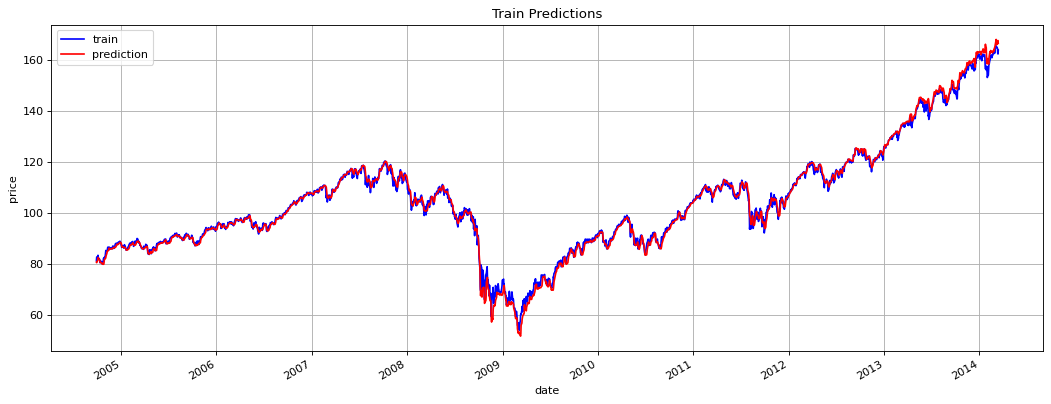

In [33]:
plt.figure(figsize=(16, 6), dpi=80, facecolor='w')

train_predict_df = pd.DataFrame({'predict': train_predict}, index=y_train.index)

ax = y_train.plot(style='b', grid=True)
ax = train_predict_df.plot(style='r', grid=True, ax=ax)

ax.legend(['train', 'prediction'])
ax.set_xlabel('date')
ax.set_ylabel('price')
ax.set_title('Train Predictions')

In [34]:
# predicting validation data

valid_predict_scaled = model.predict(X_valid_scaled)
valid_predict = valid_predict_scaled * valid['SPY_std'] + valid['SPY_mean']
original_rmse = math.sqrt(mean_squared_error(y_valid, valid_predict))

print(f'RMSE: {original_rmse}')

RMSE: 1.936996638660791


Not scaling the targets made it so the predictions were within the ranges of the training set. After scaling predictions

Text(0.5, 1.0, 'Valid Predictions')

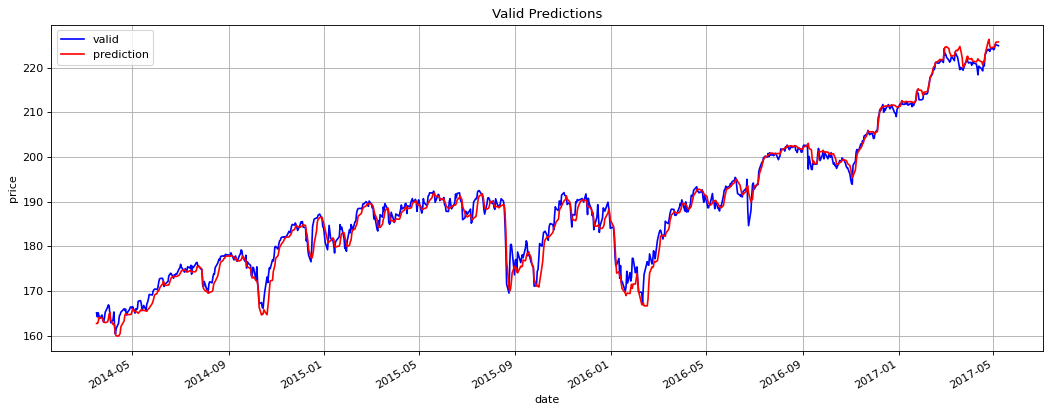

In [35]:
plt.figure(figsize=(16, 6), dpi=80, facecolor='w')

valid_predict_df = pd.DataFrame({'predict': valid_predict}, index=y_valid.index)

ax = y_valid.plot(style='b', grid=True)
ax = valid_predict_df.plot(style='r', grid=True, ax=ax)

ax.legend(['valid', 'prediction'])
ax.set_xlabel('date')
ax.set_ylabel('price')
ax.set_title('Valid Predictions')

In [36]:
# parameters
# n_estimators = 100
# max_depth = 3
# learning_rate = 0.1
# gamma=0
# min_child_weight=1
# subsample=1
# colsample_bytree=1
# colsample_by_level=1

<h5>Parameter Adjustments</h5>

In [37]:
# function to run model
def train_xgb_model(X_train,
                    y_train,
                    X_test,
                    y_test,
                    mean = valid['SPY_mean'],
                    std = valid['SPY_std'],
                    n_estimators = n_estimators,
                    max_depth = max_depth,
                    learning_rate = learning_rate,
                    gamma = gamma,
                    min_child_weight = min_child_weight,
                    subsample = subsample,
                    colsample_bytree = colsample_bytree,
                    reg_alpha = 0,
                    random_state=0):
    
    xgb = XGBRegressor(n_estimators=n_estimators,
                       max_depth=max_depth,
                       learning_rate=learning_rate,
                       gamma=gamma,
                       min_child_weight=min_child_weight,
                       subsample=subsample,
                       colsample_bytree=colsample_bytree,
                       reg_alpha=reg_alpha,
                       random_state=0)

    xgb.fit(X_train, y_train)

    train_predict_scaled = xgb.predict(X_test)

    train_predict = train_predict_scaled * std + mean

    return math.sqrt(mean_squared_error(y_test, train_predict)), train_predict

<h5>max_depth & min_child_weight</h5>
- parameters to control complexitity of trees
- tune together to find trade off between bias and variance

<b>max_depth</b> - maximum number of nodes allowed from the root to the farthest leaf of a tree; deeper trees lead to overfitting<br>
<b>min_child_weight</b> - minimum weight required to create a new node; smaller weights creates child leafs with fewer samples that can lead to overfitting

default values:
max_depth = 3,
min_child_weight = 1

In [38]:
max_depth_range = range(1,11)
min_child_weight_range = range(1,16)

error_rate = {'max_depth':[], 'min_child_weight':[], 'rmse':[]}

for param in max_depth_range:
    for param2 in min_child_weight_range:
        result, _ = train_xgb_model(X_train_scaled,
                                    y_train_scaled,
                                    X_valid_scaled,
                                    y_valid,
                                    max_depth = param,
                                    min_child_weight = param2)

        error_rate['max_depth'].append(param)
        error_rate['min_child_weight'].append(param2)
        error_rate['rmse'].append(result)

error_rate_df = pd.DataFrame(error_rate)
error_rate_df.head()

,max_depth,min_child_weight,rmse
0,1,1,1.913832
1,1,2,1.913832
2,1,3,1.913832
3,1,4,1.913832
4,1,5,1.913832


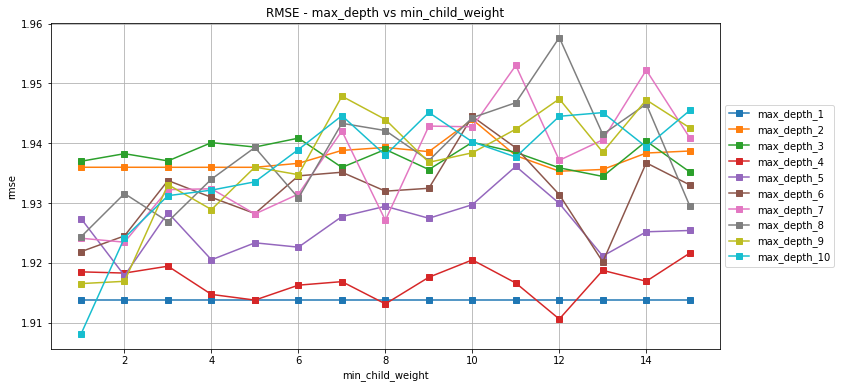

In [39]:
rcParams['figure.figsize'] = 12, 6
#plt.figure(figsize=(16, 6), dpi=80, facecolor='w')

legend_list = ['max_depth_1']

ax = error_rate_df[error_rate_df['max_depth'] == 1].plot(x='min_child_weight', y='rmse', marker='s', grid=True)

for i in max_depth_range[1:]:
    temp = error_rate_df[error_rate_df['max_depth'] == i]
    ax = temp.plot(x='min_child_weight', y='rmse', marker='s', grid=True, ax=ax)
    legend_list.append(f'max_depth_{i}')

ax.set_xlabel('min_child_weight')
ax.set_ylabel('rmse')
ax.set_title('RMSE - max_depth vs min_child_weight')
plt.legend(legend_list, loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.gcf().set_facecolor('white')

In [40]:
temp = error_rate_df[error_rate_df['rmse'] == error_rate_df['rmse'].min()]
min_rmse = temp['rmse'].iloc[0]
new_max_depth = temp['max_depth'].iloc[0]
new_min_child_weight = temp['min_child_weight'].iloc[0]

print(f'Minimum RMSE: {min_rmse}')
print(f'Optimal max_depth: {new_max_depth}')
print(f'Optimal min_child_weight: {new_min_child_weight}')
# Minimum RMSE: 1.9081235958889444

Minimum RMSE: 1.9081235958889444
Optimal max_depth: 10
Optimal min_child_weight: 1


<h5>subsample & colsample_bytree</h5>
- parameters to control sampling of dataset done at each boosting round

<b>subsample</b> - subsample of observations; 1 means to use all rows<br>
<b>colsample_bytree</b> - subsample of featuers; 1 means to use all columns

default values: subsample = 1, colsample_bytree = 1

In [41]:
subsample_range = [i/10 for i in range(1,11)]
colsample_bytree_range = [i/10 for i in range(1,11)]

error_rate = {'subsample':[], 'colsample_bytree':[], 'rmse':[]}

for param in subsample_range:
    for param2 in colsample_bytree_range:
        result, _ = train_xgb_model(X_train_scaled,
                                    y_train_scaled,
                                    X_valid_scaled,
                                    y_valid,
                                    subsample = param,
                                    colsample_bytree = param2,
                                    max_depth = new_max_depth,
                                    min_child_weight = new_min_child_weight)

        error_rate['subsample'].append(param)
        error_rate['colsample_bytree'].append(param2)
        error_rate['rmse'].append(result)

error_rate_df = pd.DataFrame(error_rate)
error_rate_df.head()

,subsample,colsample_bytree,rmse
0,0.1,0.1,1.782835
1,0.1,0.2,1.793148
2,0.1,0.3,1.840586
3,0.1,0.4,1.841138
4,0.1,0.5,1.864856


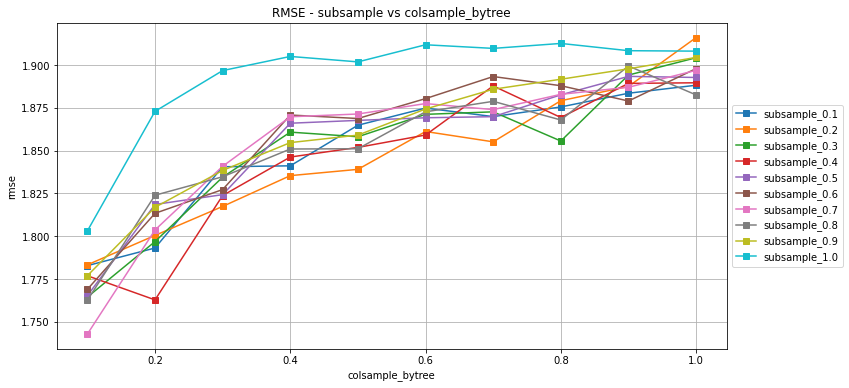

In [42]:
rcParams['figure.figsize'] = 12, 6

legend_list = ['subsample_0.1']

ax = error_rate_df[error_rate_df['subsample'] == 0.1].plot(x='colsample_bytree', y='rmse', marker='s', grid=True)

for i in subsample_range[1:]:
    temp = error_rate_df[error_rate_df['subsample'] == i]
    ax = temp.plot(x='colsample_bytree', y='rmse', marker='s', grid=True, ax=ax)
    legend_list.append(f'subsample_{i}')

ax.set_xlabel('colsample_bytree')
ax.set_ylabel('rmse')
ax.set_title('RMSE - subsample vs colsample_bytree')
plt.legend(legend_list, loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.gcf().set_facecolor('white')

In [43]:
temp = error_rate_df[error_rate_df['rmse'] == error_rate_df['rmse'].min()]
min_rmse = temp['rmse'].iloc[0]
new_subsample = temp['subsample'].iloc[0]
new_colsample_bytree = temp['colsample_bytree'].iloc[0]

print(f'Minimum RMSE: {min_rmse}')
print(f'Optimal subsample: {new_subsample}')
print(f'Optimal colsamble_bytree: {new_colsample_bytree}')

Minimum RMSE: 1.7428663149090713
Optimal subsample: 0.7
Optimal colsamble_bytree: 0.1


<h5>gamma</h5>
- tuning gamma individually, tuning it last before (n_estimators & learning_rate) because it depends on other parameters<br>
- might retune other parameters later

<b>gamma</b> - minimum loss reduction required to make a split on leaf node; higher means more regularization (less overfitting... i think)

default values: gamma = 0

In [44]:
gamma_range = [i/10 for i in range(1,11)]

error_rate = {'gamma':[], 'rmse':[]}

for param in gamma_range:
    result, _ = train_xgb_model(X_train_scaled,
                                y_train_scaled,
                                X_valid_scaled,
                                y_valid,
                                max_depth = new_max_depth,
                                min_child_weight = new_min_child_weight,
                                subsample = new_subsample,
                                colsample_bytree = new_colsample_bytree,
                                gamma = param)

    error_rate['gamma'].append(param)
    error_rate['rmse'].append(result)

error_rate_df = pd.DataFrame(error_rate)
error_rate_df.head()

,gamma,rmse
0,0.1,1.759588
1,0.2,1.762962
2,0.3,1.775355
3,0.4,1.762250
4,0.5,1.769332


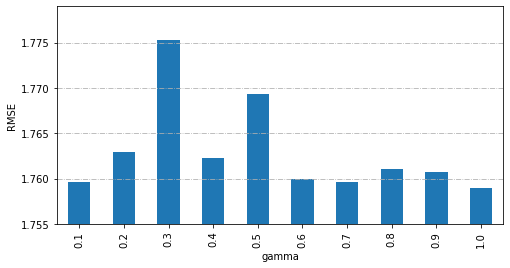

In [45]:
rcParams['figure.figsize'] = 8, 4

ax = error_rate_df.plot.bar(x='gamma', y='rmse')
ax.set_ylim(1.755, 1.779, auto=True)
ax.yaxis.grid(linestyle='-.')
ax.get_legend().remove()
ax.set_ylabel('RMSE')
plt.gcf().set_facecolor('white')

In [46]:
temp = error_rate_df[error_rate_df['rmse'] == error_rate_df['rmse'].min()]
min_rmse = temp['rmse'].iloc[0]
new_gamma = temp['gamma'].iloc[0]

print(f'Minimum RMSE: {min_rmse}')
print(f'Optimal gamma: {new_gamma}')
# Minimum RMSE: 1.758953958338571

Minimum RMSE: 1.758953958338571
Optimal gamma: 1.0


<h5>reg_alpha</h5>
- parameter to reduce overfitting

<b>reg_alpha</b> - L1 regularization term on weight<br>

default values: reg_alpha = 0

Extra notes:</b>
After starting from the default reg_alpha value and experimenting with different ranges, it looks clear that a high reg_alpha value produces a lower RMSE. Will have to study more into this. Also, I tried the reg_lambda parameter but it doesn't seem to be making a difference so I excluded it.

In [47]:
reg_alpha_range = [300, 350, 400, 450, 500, 550, 600]

error_rate = {'reg_alpha':[], 'rmse':[]}

for param in reg_alpha_range:
    result, _ = train_xgb_model(X_train_scaled,
                                y_train_scaled,
                                X_valid_scaled,
                                y_valid,
                                max_depth = new_max_depth,
                                min_child_weight = new_min_child_weight,
                                subsample = new_subsample,
                                colsample_bytree = new_colsample_bytree,
                                gamma = new_gamma,
                                reg_alpha = param)

    error_rate['reg_alpha'].append(param)
    error_rate['rmse'].append(result)

error_rate_df = pd.DataFrame(error_rate)
error_rate_df.head()

,reg_alpha,rmse
0,300,1.598190
1,350,1.589218
2,400,1.583537
3,450,1.580392
4,500,1.582040


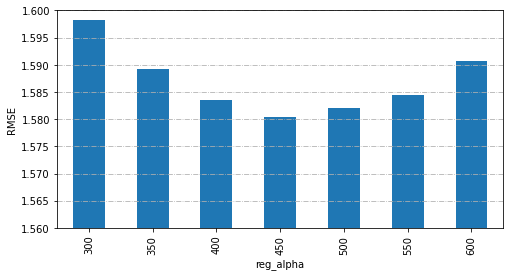

In [48]:
rcParams['figure.figsize'] = 8, 4

ax = error_rate_df.plot.bar(x='reg_alpha', y='rmse')
ax.set_ylim(1.56, 1.6, auto=True)
ax.yaxis.grid(linestyle='-.')
ax.get_legend().remove()
ax.set_ylabel('RMSE')
plt.gcf().set_facecolor('white')

In [49]:
temp = error_rate_df[error_rate_df['rmse'] == error_rate_df['rmse'].min()]
min_rmse = temp['rmse'].iloc[0]
new_reg_alpha = temp['reg_alpha'].iloc[0]

print(f'Minimum RMSE: {min_rmse}')
print(f'Optimal reg_alpha: {new_reg_alpha}')
# Minimum RMSE: 1.5803920689568765

Minimum RMSE: 1.5803920689568765
Optimal reg_alpha: 450


<h5>learning_rate & n_estimators</h5>
- parameters to control sampling of dataset done at each boosting round

<b>learning_rate</b> - amount to correct for each iteration<br>
<b>n_estimators</b> - number of gradient boosted trees

default values: learning_rate = 0.1, n_estimators = 100

In [50]:
learning_rate_range = [0.01, 0.05, 0.1, 0.2, 0.3]
n_estimators_range = range(10, 510, 10)

error_rate = {'learning_rate':[], 'n_estimators':[], 'rmse':[]}

for param in learning_rate_range:
    for param2 in n_estimators_range:
        result, _ = train_xgb_model(X_train_scaled,
                                    y_train_scaled,
                                    X_valid_scaled,
                                    y_valid,
                                    max_depth = new_max_depth,
                                    min_child_weight = new_min_child_weight,
                                    subsample = new_subsample,
                                    colsample_bytree = new_colsample_bytree,
                                    gamma = new_gamma,
                                    reg_alpha = new_reg_alpha,
                                    learning_rate = param,
                                    n_estimators = param2)

        error_rate['learning_rate'].append(param)
        error_rate['n_estimators'].append(param2)
        error_rate['rmse'].append(result)

error_rate_df = pd.DataFrame(error_rate)
error_rate_df.head()

,learning_rate,n_estimators,rmse
0,0.01,10,1.730276
1,0.01,20,1.704895
2,0.01,30,1.686519
3,0.01,40,1.671797
4,0.01,50,1.657291


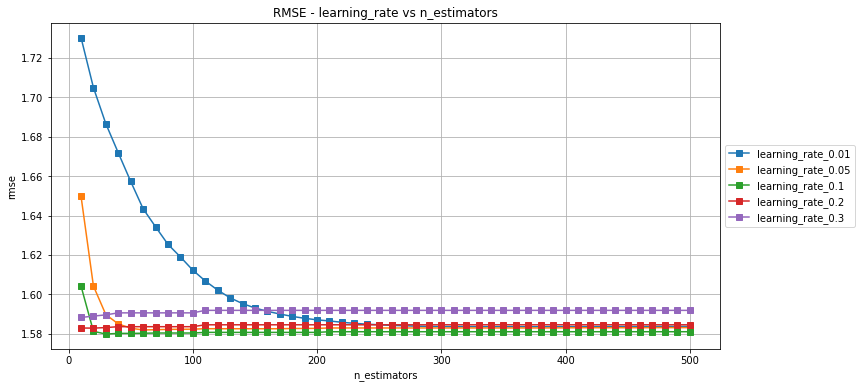

In [51]:
rcParams['figure.figsize'] = 12, 6

legend_list = ['learning_rate_0.01']

ax = error_rate_df[error_rate_df['learning_rate'] == 0.01].plot(x='n_estimators', y='rmse', marker='s', grid=True)

for i in learning_rate_range[1:]:
    temp = error_rate_df[error_rate_df['learning_rate'] == i]
    ax = temp.plot(x='n_estimators', y='rmse', marker='s', grid=True, ax=ax)
    legend_list.append(f'learning_rate_{i}')

ax.set_xlabel('n_estimators')
ax.set_ylabel('rmse')
ax.set_title('RMSE - learning_rate vs n_estimators')
plt.legend(legend_list, loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.gcf().set_facecolor('white')

In [52]:
temp = error_rate_df[error_rate_df['rmse'] == error_rate_df['rmse'].min()]
min_rmse = temp['rmse'].iloc[0]
new_learning_rate = temp['learning_rate'].iloc[0]
new_n_estimators = temp['n_estimators'].iloc[0]

print(f'Minimum RMSE: {min_rmse}')
print(f'Optimal learning_rate: {new_learning_rate}')
print(f'Optimal n_estimators: {new_n_estimators}')
# Minimum RMSE: 1.5798614624874132

Minimum RMSE: 1.5798599833836628
Optimal learning_rate: 0.1
Optimal n_estimators: 30


<h5>Optimal Parameters</h5>

In [53]:
tuned_params_df = {'param': ['n_estimators', 'max_depth', 'learning_rate', 'gamma',
                             'min_child_weight', 'subsample', 'colsample_bytree',
                             'reg_alpha', 'rmse'],
                   'original': [n_estimators, max_depth, learning_rate, gamma,
                                min_child_weight, subsample, colsample_bytree, 
                                reg_alpha, original_rmse],
                   'after_tuning': [new_n_estimators, new_max_depth, new_learning_rate, new_gamma,
                                    new_min_child_weight, new_subsample, new_colsample_bytree,
                                    new_reg_alpha, min_rmse]}
tuned_params_df = pd.DataFrame(tuned_params_df)
tuned_params_df

,param,original,after_tuning
0,n_estimators,100.000000,30.00000
1,max_depth,3.000000,10.00000
2,learning_rate,0.100000,0.10000
3,gamma,0.000000,1.00000
4,min_child_weight,1.000000,1.00000
5,subsample,1.000000,0.70000
6,colsample_bytree,1.000000,0.10000
7,reg_alpha,0.000000,450.00000
8,rmse,1.936997,1.57986


In [54]:
final_rmse, final_predict = train_xgb_model(X_train = X_train_valid_scaled,
                                            y_train = y_train_valid_scaled,
                                            X_test = X_test_scaled,
                                            y_test = y_test,
                                            mean = test['SPY_mean'],
                                            std = test['SPY_std'],
                                            n_estimators = new_n_estimators,
                                            max_depth = new_max_depth,
                                            learning_rate = new_learning_rate,
                                            gamma = new_gamma,
                                            min_child_weight = new_min_child_weight,
                                            subsample = new_subsample,
                                            colsample_bytree = new_colsample_bytree,
                                            reg_alpha = new_reg_alpha,
                                            random_state = 0)

print("RMSE on test set = %0.3f" % final_rmse)
#RMSE on test set = 3.878

RMSE on test set = 3.878


Text(0.5, 1.0, 'Test Predictions')

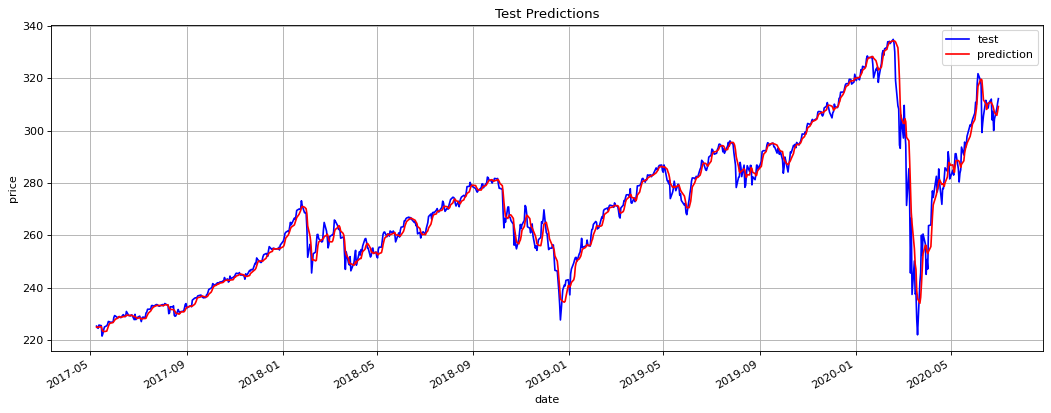

In [55]:
plt.figure(figsize=(16, 6), dpi=80, facecolor='w')

test_predict_df = pd.DataFrame({'predict': final_predict}, index=y_test.index)

ax = y_test.plot(style='b', grid=True)
ax = test_predict_df.plot(style='r', grid=True, ax=ax)

ax.legend(['test', 'prediction'])
ax.set_xlabel('date')
ax.set_ylabel('price')
ax.set_title('Test Predictions')

The results for the final test sets were disappointing, with an RSME of 4.56 compared to the 1.74 of the validation set. Looking at the chart above we can see that there is a slight lag in predictions, especially in turns in direction of the market.

I am curious to see what happens if I exclude data after January 31st which was when the 2020 Covid crash started.

In [56]:
X_test_temp = X_test.loc[:'2020-02-01']
y_test_temp = y_test.loc[:'2020-02-01']

temp_rmse, temp_predict = train_xgb_model(X_train = X_train_valid_scaled,
                                            y_train = y_train_valid_scaled,
                                            X_test = X_test_temp,
                                            y_test = y_test_temp,
                                            mean = test.loc[:'2020-02-01']['SPY_mean'],
                                            std = test.loc[:'2020-02-01']['SPY_std'],
                                            n_estimators = new_n_estimators,
                                            max_depth = new_max_depth,
                                            learning_rate = new_learning_rate,
                                            gamma = new_gamma,
                                            min_child_weight = new_min_child_weight,
                                            subsample = new_subsample,
                                            colsample_bytree = new_colsample_bytree,
                                            reg_alpha = new_reg_alpha,
                                            random_state = 0)

print("RMSE on test set = %0.3f" % temp_rmse)

RMSE on test set = 2.814


Text(0.5, 1.0, 'Test Predictions')

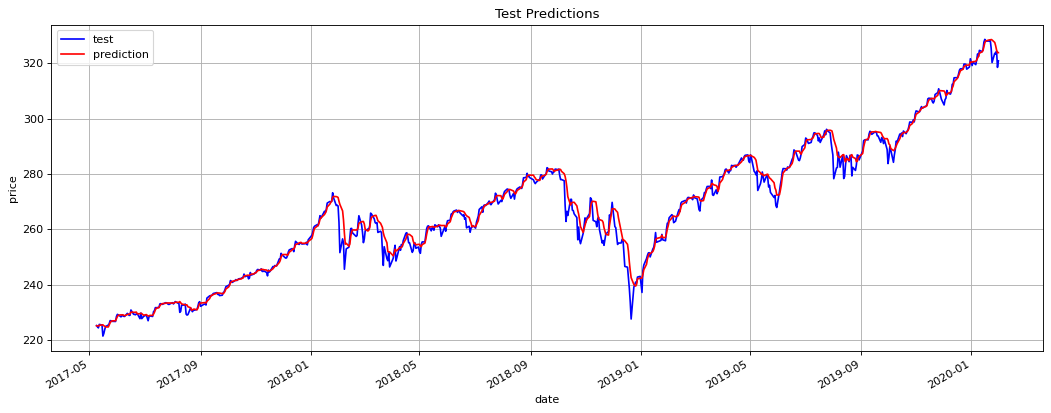

In [57]:
plt.figure(figsize=(16, 6), dpi=80, facecolor='w')

temp_predict_df = pd.DataFrame({'predict': temp_predict}, index=y_test.loc[:'2020-02-01'].index)

ax = y_test.loc[:'2020-02-01'].plot(style='b', grid=True)
ax = temp_predict_df.plot(style='r', grid=True, ax=ax)

ax.legend(['test', 'prediction'])
ax.set_xlabel('date')
ax.set_ylabel('price')
ax.set_title('Test Predictions')

For this iteration I switched from obtaining the data from local CSV files to a SQL database after being able to upload all historical data into a personal SQL server. The next step for the data sources is to write and schedule scripts that will web scrape data and upload to the server weekly/monthly.

In this analysis I revised a few features, particularily removing the DIX and GEX index. This contributed to an improvement in RMSE score as now the model has an extra ~10 years worth of data to work with. I was able to get the RMSE score from 4.562 to 4.169 for all data and from 4.012 to 3.434 for pre February 2020 data.

I also added the reg_alpha parameter which was crucial in improving RMSE score from 4.562 to 3.878 for all data and 4.012 to 2.814 for before February 2020 prices. The previous model was definitely overfitting.


The next steps to improving this model:
- predict the next 15/30 days (remember to account for weekends)
- break out each financial feature groups and filter out the low performing ones
- feature engineering (add industry ticker data and volume, % change, etc.)
- explore other scaling methods

To do list:
- write scripts that will continuously upload new data into server
- explore adding options data if possible
- find a way to predict trend data (trend line for week/month out)
- try other prediction models
- try DNN models (tensorflow) 

4.602297025923077


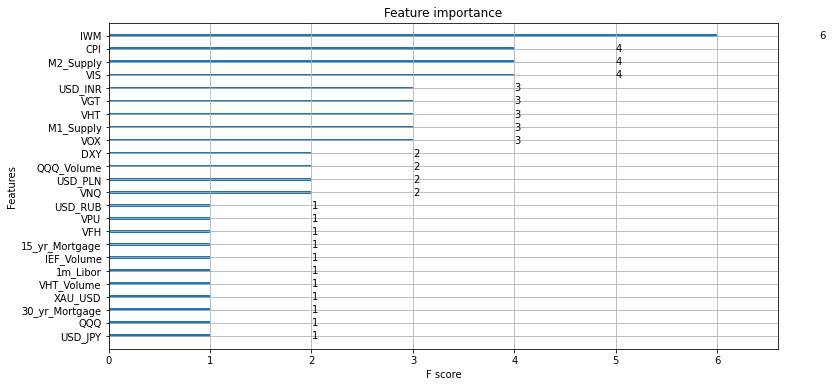

In [58]:
import xgboost as xgb

xgb_clf = XGBRegressor(n_estimators=new_n_estimators,
                       max_depth=new_max_depth,
                       learning_rate=new_learning_rate,
                       gamma=new_gamma,
                       min_child_weight=new_min_child_weight,
                       subsample=new_subsample,
                       colsample_bytree=new_colsample_bytree,
                       reg_alpha = new_reg_alpha,
                       random_state=0)

xgb_clf.fit(X_train_valid_scaled, y_train_valid_scaled)
prediction_scaled = xgb_clf.predict(X_test)

train_predict = prediction_scaled * test['SPY_std'] + test['SPY_mean']

print(math.sqrt(mean_squared_error(y_test, train_predict)))

xgb.plot_importance(xgb_clf)